#  <span style="color:orange">Final Project</span>

# 0.0 Configurar MLFlow

In [ ]:
import mlflow
import os

# you can set your tracking server URI programmatically:
mlflow.set_tracking_uri('https://mlflow-aie3.ai.spglobal.com/')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'https://minio-aie3.ai.spglobal.com/'
os.environ['LOGNAME'] = 'oswaldo'

# 1.0 Importar datos de entrenamiento

In [ ]:
import pandas as pd
dataset = pd.read_csv("training.csv")

In [ ]:
dataset.dropna(inplace=True)

In [ ]:
#check the shape of data
dataset.shape

In [ ]:
dataset['Points'].describe()

In [ ]:
dataset.boxplot(column=['Points'])

## Convertimos la columna de punto de numérica a categórica, con dos categorías. Bueno y Malo. 

### Malo se define entre el valor mínimo teórico y la media. Bueno es entre la media y el valor máximo observado

In [ ]:
bins=[0,93,278]
names=['Bad','Good']
dataset['Points_range']=pd.cut(dataset['Points'],bins,labels=names)

In [ ]:
dataset.sort_values(by='Points_range')

# 2.0 Vamos a comenzar el experimento, en donde sólo utilizaremos las columnas no ignoradas (precedidas por un #, por ejempo #year no es ignorada. O lo que es lo mismo, es considerada)

## El objetivo es encontrar un modelo de aprendizaje automático que logre predecir la categoría de bueno/malo con base en año (categórico), bailable, energía y acustica de las canciones utilizando Spotify API get-audio-features y get-audio-analysis

In [9]:
from pycaret.classification import *
exp_mclf101 = setup(data = dataset,
                    target = 'Points_range',
                    session_id=123,
                    # Todas las columnas que tienen un hash (#), serán incluidas para el análisis
                    ignore_features=[#'duration',
                                     'key',
                                     #'loudness',
                                     'mode',
                                     #'tempo',
                                     'artist_hotttnesss',
                                     'end_of_fade_in',
                                     'start_of_fade_out',
                                     'mode_confidence',                       
                                     'key_confidence',
                                     'time_signature',
                                     'time_signature_confidence',
                                     'year',
                                     'popularity', 
                                     #'danceability',
                                     #'energy',
                                     #'speechiness',
                                     #'acousticness',
                                     'instrumentalness',
                                     'liveness',
                                     #'valence',
                                     'duration_ms',
                                     'Points',
                                     'Country',
                                     #'Points_range',
                                    ],
                    log_experiment=True,
                    experiment_name="Final_paper_final6",
                    log_plots=True,
                    profile=False,
                    use_gpu=True) 

,Description,Value
0,session_id,123
1,Target,Points_range
2,Target Type,Binary
3,Label Encoded,"Bad: 0, Good: 1"
4,Original Data,"(85, 25)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


# 3.0 Comparando múltiples modelos

## Vamos a ordenarlos de mayor a menor precisión

In [10]:
best = compare_models(sort='Precision')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.6433,0.6333,0.6417,0.6558,0.6265,0.2833,0.2955,0.1020
gbc,Gradient Boosting Classifier,0.6133,0.6222,0.6167,0.6508,0.6002,0.2282,0.2602,0.0740
knn,K Neighbors Classifier,0.5767,0.5889,0.5750,0.6117,0.5631,0.1500,0.1809,0.3510
et,Extra Trees Classifier,0.5067,0.5444,0.5000,0.4892,0.4768,-0.0030,0.0079,0.7900
rf,Random Forest Classifier,0.4767,0.5278,0.4750,0.4725,0.4629,-0.0500,-0.0540,0.8800
dt,Decision Tree Classifier,0.5000,0.5000,0.5000,0.4667,0.4743,0.0000,-0.0081,0.0120
catboost,CatBoost Classifier,0.4600,0.5389,0.4583,0.4333,0.4376,-0.0833,-0.1061,1.5030
lr,Logistic Regression,0.4267,0.3889,0.4250,0.4225,0.4104,-0.1500,-0.1540,0.0270
lightgbm,Light Gradient Boosting Machine,0.4567,0.4222,0.4583,0.3858,0.4048,-0.0821,-0.1248,0.0200
qda,Quadratic Discriminant Analysis,0.4033,0.4222,0.4083,0.3733,0.3654,-0.1762,-0.1913,0.0120


# 3.0 Crearemos 3 objetos modelo que presentaron las métricas más altas de Precisión

### Gradient Boosting Classifier

In [11]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.8889,0.6667,0.6667,0.6667,0.3333,0.3333
1,0.3333,0.3333,0.3333,0.3333,0.3333,-0.3333,-0.3333
2,0.8333,1.0000,0.8333,0.8750,0.8286,0.6667,0.7071
3,0.6667,0.6667,0.6667,0.6667,0.6667,0.3333,0.3333
4,0.6667,0.5556,0.6667,0.8000,0.6250,0.3333,0.4472
5,0.5000,0.5556,0.5000,0.5000,0.4857,0.0000,0.0000
6,0.5000,0.3333,0.5000,0.5000,0.4857,0.0000,0.0000
7,0.6667,0.3333,0.6667,0.8000,0.6250,0.3333,0.4472
8,0.5000,0.5556,0.5000,0.5000,0.4857,0.0000,0.0000
9,0.8000,1.0000,0.8333,0.8667,0.8000,0.6154,0.6667


In [12]:
#trained model object is stored in the variable 'dt'. 
print(gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Random Forest

In [13]:
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5000,0.6667,0.5000,0.5000,0.4857,0.0000,0.0000
1,0.6667,0.7778,0.6667,0.8000,0.6250,0.3333,0.4472
2,0.8333,0.8889,0.8333,0.8750,0.8286,0.6667,0.7071
3,0.8333,0.7222,0.8333,0.8750,0.8286,0.6667,0.7071
4,0.6667,0.7222,0.6667,0.8000,0.6250,0.3333,0.4472
5,0.5000,0.4444,0.5000,0.5000,0.4857,0.0000,0.0000
6,0.5000,0.3889,0.5000,0.5000,0.4857,0.0000,0.0000
7,0.3333,0.3889,0.3333,0.3333,0.3333,-0.3333,-0.3333
8,0.3333,0.2222,0.3333,0.3333,0.3333,-0.3333,-0.3333
9,0.6000,0.6667,0.5833,0.6000,0.6000,0.1667,0.1667


### Ada Boost Classifier	

In [14]:
ada = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.6667,0.6667,0.8000,0.6250,0.3333,0.4472
1,0.3333,0.5556,0.3333,0.2000,0.2500,-0.3333,-0.4472
2,0.8333,1.0000,0.8333,0.8750,0.8286,0.6667,0.7071
3,0.6667,0.6667,0.6667,0.6667,0.6667,0.3333,0.3333
4,0.8333,0.7778,0.8333,0.8750,0.8286,0.6667,0.7071
5,0.5000,0.3333,0.5000,0.5000,0.4857,0.0000,0.0000
6,0.6667,0.5556,0.6667,0.6667,0.6667,0.3333,0.3333
7,0.5000,0.3333,0.5000,0.5000,0.4857,0.0000,0.0000
8,0.8333,0.7778,0.8333,0.8750,0.8286,0.6667,0.7071
9,0.6000,0.6667,0.5833,0.6000,0.6000,0.1667,0.1667


# 4.0 Vamos a afinar los hiperparámetros buscando maximizar la precisión

### Gradient Boosting Classifier

In [35]:
tuned_gbc = tune_model(gbc,optimize = 'Precision',choose_better=True,n_iter=1000)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5000,0.5556,0.5000,0.5000,0.4857,0.0000,0.0000
1,0.8333,0.6667,0.8333,0.8750,0.8286,0.6667,0.7071
2,0.8333,0.8889,0.8333,0.8750,0.8286,0.6667,0.7071
3,0.5000,0.6667,0.5000,0.5000,0.4857,0.0000,0.0000
4,0.8333,0.7778,0.8333,0.8750,0.8286,0.6667,0.7071
5,0.8333,0.8889,0.8333,0.8750,0.8286,0.6667,0.7071
6,0.6667,0.6667,0.6667,0.6667,0.6667,0.3333,0.3333
7,0.6667,0.3333,0.6667,0.8000,0.6250,0.3333,0.4472
8,0.6667,0.5556,0.6667,0.8000,0.6250,0.3333,0.4472
9,0.6000,0.6667,0.5833,0.6000,0.6000,0.1667,0.1667


In [36]:
#tuned model object is stored in the variable 'tuned_dt'. 
print(tuned_gbc)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.368, loss='deviance', max_depth=2,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.002, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=240,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=0.85, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Random Forest

In [38]:
tuned_knn = tune_model(knn,optimize = 'Precision',choose_better=True,n_iter=1000)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8333,0.6667,0.8333,0.8750,0.8286,0.6667,0.7071
1,0.6667,0.4444,0.6667,0.8000,0.6250,0.3333,0.4472
2,0.8333,0.8889,0.8333,0.8750,0.8286,0.6667,0.7071
3,0.6667,0.7778,0.6667,0.6667,0.6667,0.3333,0.3333
4,0.3333,0.4444,0.3333,0.2000,0.2500,-0.3333,-0.4472
5,0.6667,0.5556,0.6667,0.6667,0.6667,0.3333,0.3333
6,0.6667,0.5556,0.6667,0.6667,0.6667,0.3333,0.3333
7,0.6667,0.4444,0.6667,0.6667,0.6667,0.3333,0.3333
8,0.8333,0.6667,0.8333,0.8750,0.8286,0.6667,0.7071
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


### Ada Boost Classifier	

In [39]:
tuned_ada = tune_model(ada,optimize = 'Precision',choose_better=True,n_iter=1000)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.6667,0.6667,0.8000,0.6250,0.3333,0.4472
1,0.6667,0.4444,0.6667,0.8000,0.6250,0.3333,0.4472
2,0.8333,0.7778,0.8333,0.8750,0.8286,0.6667,0.7071
3,0.6667,0.6667,0.6667,0.6667,0.6667,0.3333,0.3333
4,0.8333,0.7778,0.8333,0.8750,0.8286,0.6667,0.7071
5,0.6667,0.5556,0.6667,0.6667,0.6667,0.3333,0.3333
6,0.6667,0.4444,0.6667,0.6667,0.6667,0.3333,0.3333
7,0.6667,0.6667,0.6667,0.8000,0.6250,0.3333,0.4472
8,0.6667,0.4444,0.6667,0.8000,0.6250,0.3333,0.4472
9,0.6000,0.6667,0.5833,0.6000,0.6000,0.1667,0.1667


# 5.0 Gráficas de los modelos afinados

### Matriz de confusión

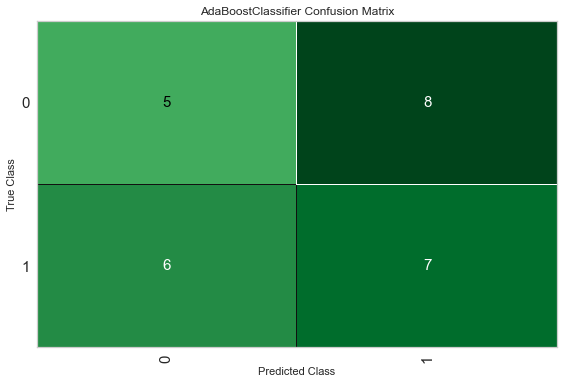

In [40]:
plot_model(tuned_ada, plot = 'confusion_matrix')

### Mapa de decisión

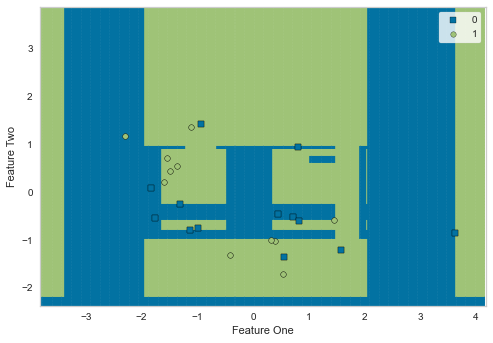

In [41]:
plot_model(tuned_ada, plot='boundary')

### Error

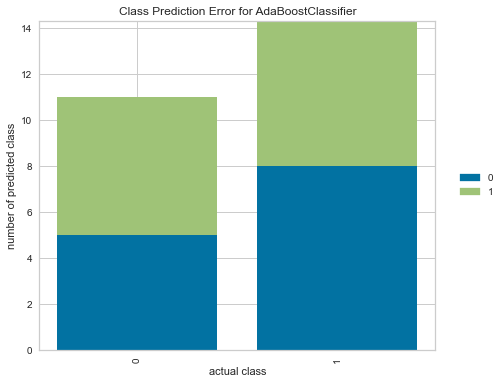

In [42]:
plot_model(tuned_ada, plot = 'error')

### Seleccionar dinámicamente las gráficas

In [43]:
evaluate_model(tuned_ada)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# 6.0 Predicción en el conjunto de entrenamiento

In [44]:
predict_model(tuned_ada);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.4615,0.4024,0.4615,0.4606,0.4583,-0.0769,-0.0778


In [67]:
predict_model(tuned_knn);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.5769,0.5325,0.5769,0.5812,0.5712,0.1538,0.1581


In [68]:
predict_model(tuned_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.4231,0.5266,0.4231,0.4188,0.4153,-0.1538,-0.1581


# 7.0 Entrenaremos sobre el 100% de los datos ya que el modelo fue afinado y está listo para producción

In [45]:
final_ada = finalize_model(tuned_ada)

In [53]:
final_knn = finalize_model(tuned_knn)

In [54]:
final_gbc = finalize_model(tuned_gbc)

In [55]:
#Final K Nearest Neighbour parameters for deployment
print(final_ada)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.495, n_estimators=130, random_state=123)


# 8.0 Serializamos el modelo

In [56]:
save_model(final_ada,'Final ada Model 08Feb2020')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['key', 'mode',
                                                        'artist_hotttnesss',
                                                        'end_of_fade_in',
                                                        'start_of_fade_out',
                                                        'mode_confidence',
                                                        'key_confidence',
                                                        'time_signature',
                                                        'time_signature_confidence',
                                                        'year', 'popularity',
                                                        'instrumentalness',
                                                        'liveness

In [57]:
save_model(final_knn,'Final knn Model 08Feb2020')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['key', 'mode',
                                                        'artist_hotttnesss',
                                                        'end_of_fade_in',
                                                        'start_of_fade_out',
                                                        'mode_confidence',
                                                        'key_confidence',
                                                        'time_signature',
                                                        'time_signature_confidence',
                                                        'year', 'popularity',
                                                        'instrumentalness',
                                                        'liveness

In [58]:
save_model(final_gbc,'Final gbc Model 08Feb2020')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['key', 'mode',
                                                        'artist_hotttnesss',
                                                        'end_of_fade_in',
                                                        'start_of_fade_out',
                                                        'mode_confidence',
                                                        'key_confidence',
                                                        'time_signature',
                                                        'time_signature_confidence',
                                                        'year', 'popularity',
                                                        'instrumentalness',
                                                        'liveness

(TIP : It's always good to use date in the filename when saving models, it's good for version control.)

# 9.0 Cargamos el modelo serializado

In [48]:
saved_final_ada = load_model('Final ada Model 08Feb2020')

Transformation Pipeline and Model Successfully Loaded


In [59]:
saved_final_knn = load_model('Final ada Model 08Feb2020')

Transformation Pipeline and Model Successfully Loaded


In [60]:
saved_final_gbc = load_model('Final ada Model 08Feb2020')

Transformation Pipeline and Model Successfully Loaded


# 10.0 Vamos a traer datos que no ha visto nunca el modelo ya que son los que buscamos predecir. Los datos de JESC 2020 analizados por Spotify API

Evidentenemtnte estos datos no contienen la puntuación, ya que es lo que buscamos predecir

In [49]:
data_unseen=pd.read_csv("final.csv")
data_unseen

,duration,key,loudness,mode,tempo,artist_hotttnesss,end_of_fade_in,start_of_fade_out,mode_confidence,key_confidence,...,popularity,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,duration_ms,Country
0,181.99773,7,-9.342,0,95.001,0.23,0.00000,178.39311,0.873,0.876,...,35,0.565,0.563,0.0296,0.1310,0.000002,0.2530,0.114,181998,Belarus
1,179.98036,0,-3.938,1,113.932,0.26,0.00000,173.35439,0.636,0.742,...,38,0.758,0.647,0.0419,0.4330,0.000000,0.1720,0.597,179980,France
2,182.60023,2,-7.322,1,113.981,0.17,0.24989,176.25687,0.687,0.619,...,28,0.667,0.405,0.0292,0.5470,0.000000,0.1920,0.329,182600,Germany
3,173.16830,6,-6.834,1,101.021,0.35,0.15116,168.11247,0.768,0.742,...,46,0.611,0.623,0.0367,0.0569,0.000045,0.0930,0.428,173168,Netherlands
4,180.54675,0,-2.799,1,122.028,0.31,0.00000,173.85940,0.490,0.546,...,42,0.523,0.851,0.0373,0.0148,0.000001,0.2920,0.181,180547,Poland
5,177.33333,8,-6.671,1,180.020,0.14,0.00000,169.28508,0.311,0.507,...,26,0.258,0.499,0.0377,0.4550,0.000000,0.0773,0.428,177333,Russia
6,167.98611,6,-6.184,0,100.040,0.30,2.61805,162.60934,0.379,0.062,...,42,0.744,0.574,0.1670,0.0555,0.000000,0.0817,0.353,167986,Spain
7,157.90765,11,-7.370,0,153.369,0.19,0.53991,152.74086,0.655,0.696,...,31,0.359,0.497,0.0439,0.4360,0.000000,0.0787,0.328,157908,Ukraine


### Vemos las columnas para tener mayor transparencia en este conjunto de datos que deseamos predecir

In [50]:
data_unseen.columns

Index(['duration', 'key', 'loudness', 'mode', 'tempo', 'artist_hotttnesss',
       'end_of_fade_in', 'start_of_fade_out', 'mode_confidence',
       'key_confidence', 'time_signature', 'time_signature_confidence', 'year',
       'popularity', 'danceability', 'energy', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'duration_ms', 'Country'],
      dtype='object')

In [61]:
new_prediction = predict_model(saved_final_ada, data=data_unseen)

In [62]:
new_prediction2 = predict_model(saved_final_knn, data=data_unseen)

In [63]:
new_prediction3 = predict_model(saved_final_gbc, data=data_unseen)

## Esta función predice la etiqueta y el "Score" (probabilidad de la clase predicha) utilizando un modelo entrenado. 

In [64]:
pd.merge(new_prediction.sort_values(by='Label'),data_unseen['Country'],left_index=True,right_index=True).sort_values(by=['Label','Score'],ascending=False)

,duration,loudness,tempo,danceability,energy,speechiness,acousticness,valence,Label,Score,Country
4,180.54675,-2.799,122.028,0.523,0.851,0.0373,0.0148,0.181,Good,0.5494,Poland
0,181.99773,-9.342,95.001,0.565,0.563,0.0296,0.1310,0.114,Good,0.5299,Belarus
6,167.98611,-6.184,100.040,0.744,0.574,0.1670,0.0555,0.353,Good,0.5183,Spain
3,173.16830,-6.834,101.021,0.611,0.623,0.0367,0.0569,0.428,Good,0.5083,Netherlands
1,179.98036,-3.938,113.932,0.758,0.647,0.0419,0.4330,0.597,Good,0.5019,France
2,182.60023,-7.322,113.981,0.667,0.405,0.0292,0.5470,0.329,Bad,0.5371,Germany
5,177.33333,-6.671,180.020,0.258,0.499,0.0377,0.4550,0.428,Bad,0.5202,Russia
7,157.90765,-7.370,153.369,0.359,0.497,0.0439,0.4360,0.328,Bad,0.5048,Ukraine


In [65]:
pd.merge(new_prediction2.sort_values(by='Label'),data_unseen['Country'],left_index=True,right_index=True).sort_values(by=['Label','Score'],ascending=False)

,duration,loudness,tempo,danceability,energy,speechiness,acousticness,valence,Label,Score,Country
4,180.54675,-2.799,122.028,0.523,0.851,0.0373,0.0148,0.181,Good,0.5494,Poland
0,181.99773,-9.342,95.001,0.565,0.563,0.0296,0.1310,0.114,Good,0.5299,Belarus
6,167.98611,-6.184,100.040,0.744,0.574,0.1670,0.0555,0.353,Good,0.5183,Spain
3,173.16830,-6.834,101.021,0.611,0.623,0.0367,0.0569,0.428,Good,0.5083,Netherlands
1,179.98036,-3.938,113.932,0.758,0.647,0.0419,0.4330,0.597,Good,0.5019,France
2,182.60023,-7.322,113.981,0.667,0.405,0.0292,0.5470,0.329,Bad,0.5371,Germany
5,177.33333,-6.671,180.020,0.258,0.499,0.0377,0.4550,0.428,Bad,0.5202,Russia
7,157.90765,-7.370,153.369,0.359,0.497,0.0439,0.4360,0.328,Bad,0.5048,Ukraine


In [66]:
pd.merge(new_prediction3.sort_values(by='Label'),data_unseen['Country'],left_index=True,right_index=True).sort_values(by=['Label','Score'],ascending=False)

,duration,loudness,tempo,danceability,energy,speechiness,acousticness,valence,Label,Score,Country
4,180.54675,-2.799,122.028,0.523,0.851,0.0373,0.0148,0.181,Good,0.5494,Poland
0,181.99773,-9.342,95.001,0.565,0.563,0.0296,0.1310,0.114,Good,0.5299,Belarus
6,167.98611,-6.184,100.040,0.744,0.574,0.1670,0.0555,0.353,Good,0.5183,Spain
3,173.16830,-6.834,101.021,0.611,0.623,0.0367,0.0569,0.428,Good,0.5083,Netherlands
1,179.98036,-3.938,113.932,0.758,0.647,0.0419,0.4330,0.597,Good,0.5019,France
2,182.60023,-7.322,113.981,0.667,0.405,0.0292,0.5470,0.329,Bad,0.5371,Germany
5,177.33333,-6.671,180.020,0.258,0.499,0.0377,0.4550,0.428,Bad,0.5202,Russia
7,157.90765,-7.370,153.369,0.359,0.497,0.0439,0.4360,0.328,Bad,0.5048,Ukraine


- Vemos entonces que la mejor canción según el modelo es Holanda, Francia, Bielorusia y Polonia.
- Las peores serían Alemania, Rusia, España y Ukrania